In [14]:
import torch
from matplotlib import pyplot as plt
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

In [15]:
root_path = "/home/yigit/projects/mbcnp/outputs/egg/"
run_id, model_folder = '1691488118', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

cnp_model_path, wta_model_path = f'{models_path}cnp_on_synth.pt', f'{models_path}wta_on_synth.pt'

In [16]:
y = torch.load(f'{root_path}{run_id}/y.pt')
print(y.shape)

torch.Size([2, 200, 1])


In [29]:
batch_size = 1
cnp = CNP(input_dim=1, hidden_dim=160, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size)
wta = WTA_CNP(1, 1, 6, 6, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[128, 128, 128], batch_size=batch_size)

# cnp = CNP(input_dim=1, hidden_dim=256, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size)
# wta = WTA_CNP(1, 1, 6, 6, [216, 216, 216], num_decoders=2, decoder_hidden_dims=[216, 216, 216], batch_size=batch_size)

cnp.load_state_dict(torch.load(cnp_model_path))
wta.load_state_dict(torch.load(wta_model_path))

cnp.eval()
wta.eval()

WTA_CNP(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoders): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [32]:
# obs = torch.Tensor([[0, 0], [1, 0]]).unsqueeze(0)
# obs = torch.Tensor([0.5, y[1, 99, 0]]).unsqueeze(0).unsqueeze(0)
# obs = torch.Tensor([0.0, 0.0]).unsqueeze(0).unsqueeze(0)
obs = torch.Tensor([1.0, 0.0]).unsqueeze(0).unsqueeze(0)
tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1)

# obs = torch.Tensor([[[0.0, 0.00]], [[1.0, 0.0]]])
# obs = torch.Tensor([[[0.5, y[0, 99, 0]]], [[0.5, y[1, 99, 0]]]])
# tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).repeat(2,1,1)
# tar = torch.linspace(0.4, 0.6, 2).unsqueeze(0).unsqueeze(-1).repeat(2,1,1)

print(obs.shape, tar.shape)

with torch.no_grad():
    pred_cnp, _ = cnp(obs, tar)
    pred_wta, gate = wta(obs, tar)

print(pred_wta.shape, pred_cnp.shape)
print(gate)

torch.Size([1, 1, 2]) torch.Size([1, 200, 1])
torch.Size([2, 1, 200, 2]) torch.Size([1, 200, 2])
tensor([[[0.0270, 0.9730]]])


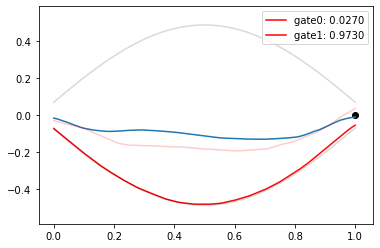

In [33]:
from matplotlib.lines import Line2D

plt_y_lim = torch.max(y) + 0.1

plt.ylim((-plt_y_lim, plt_y_lim))

if batch_size == 1:
    plt.plot(torch.linspace(0, 1, 200), pred_cnp[0,:,0])
    plt.plot(torch.linspace(0, 1, 200), pred_wta[0,0,:,0], 'r', alpha=max(0.2, gate[0, 0, 0].item()))
    plt.plot(torch.linspace(0, 1, 200), pred_wta[1,0,:,0], 'r', alpha=max(0.2, gate[0, 0, 1].item()))

    plt.scatter(obs[0, 0, 0], obs[0,0,1], c='k')
    if obs.shape[1] > 1:
        plt.scatter(obs[0, 1, 0], obs[0,1,1], c='k')
    plt.plot(torch.linspace(0, 1, 200), y[0], 'k', alpha=0.15)
    plt.plot(torch.linspace(0, 1, 200), y[1], 'k', alpha=0.15)

    line0 = Line2D([0], [0], label=f'gate0: {gate[0, 0, 0].item():.4f}', color='r')
    line1 = Line2D([0], [0], label=f'gate1: {gate[0, 0, 1].item():.4f}', color='r')

    handles = [line0, line1]

    plt.legend(handles=handles, loc='upper right')
else:
    for i in range(obs.shape[0]):
        plt.plot(torch.linspace(0, 1, 200), y[i], 'k', alpha=0.3)
        plt.plot(torch.linspace(0, 1, 200), pred_cnp[i,:,0], 'b')

        for j in range(gate.shape[-1]):
            plt.plot(torch.linspace(0, 1, 200), pred_wta[j,i,:,0], 'r', alpha=max(0.2, gate[i, 0, j].item()))

        for j in range(obs.shape[1]):
            plt.scatter(obs[i, j, 0], obs[i,j,1], c='k')

        print(gate[i, 0, :])
        

In [27]:
rr = torch.cat((torch.cat((torch.tensor(y[0, 80, :]), torch.tensor(y[0, 120, :])), dim=0).unsqueeze(0), torch.cat((torch.tensor(y[1, 80, :]), torch.tensor(y[1, 120, :])), dim=0).unsqueeze(0)), dim=0).unsqueeze(-1)
# print(rr.shape)  # 2-2-1
wta.loss(pred_wta, gate.squeeze(1), rr)

/tmp/ipykernel_8279/1920264534.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rr = torch.cat((torch.cat((torch.tensor(y[0, 80, :]), torch.tensor(y[0, 120, :])), dim=0).unsqueeze(0), torch.cat((torch.tensor(y[1, 80, :]), torch.tensor(y[1, 120, :])), dim=0).unsqueeze(0)), dim=0).unsqueeze(-1)


(tensor(-44.9983), tensor(-4.7696))

In [7]:
# plt.ylim((-2.5, 2.5))

# plt.errorbar(torch.linspace(0, 1, 200), pred_cnp[0,:,0], yerr=pred_cnp[0,:,1])
# plt.plot(torch.linspace(0, 1, 200), pred_wta[1,0,:,0], 'k')

In [8]:
# plt.ylim((-2.5, 2.5))
# ind = 0
# plt.errorbar(torch.linspace(0, 1, 200), pred_wta[ind,0,:,0], yerr=pred_wta[ind,0,:,1])